In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
%matplotlib inline
sns.set()

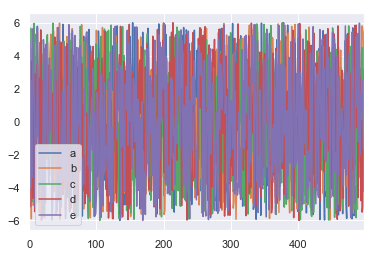

In [2]:
size_d = 500 # sample size
var_dim = 5  # dimension of variable.

x = np.array([list(np.random.permutation(np.linspace(-6, 6, size_d))) for _ in range(var_dim)]).T

df_x = pd.DataFrame(data=x, columns=['a', 'b', 'c', 'd', 'e'])
df_x.plot()
plt.show()

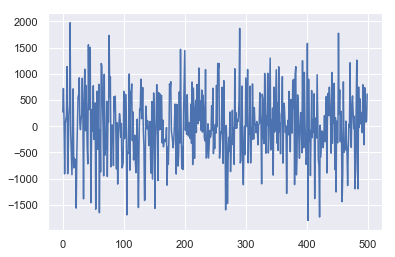

In [3]:
def obs_process(x):
    return (5*(x+3)*x*(x-3)).sum()
y_true = np.array([obs_process(_) for _ in df_x.values])
sns.lineplot(x=range(len(y_true)), y=y_true)

In [4]:
# Prepare test data.
np.random.seed(0)
y_noise = y_true + np.random.randn(size_d) * 50.0
size_p = 100
new_x_idx = np.random.permutation(df_x.index)
new_x_idx = new_x_idx[:size_p]
new_x_idx.sort()
df_new_x = df_x.loc[new_x_idx, :]
new_x = df_new_x.values
new_y_true = np.array([obs_process(_) for _ in df_new_x.values])

In [5]:
df_x.loc[:, 'y_true'] = y_true
df_x.loc[:, 'y_noise'] = y_noise
df_x['Predict_objective'] = np.nan
for i, idx in enumerate(new_x_idx):
    df_x.loc[idx, 'Predict_objective'] = new_y_true[i]

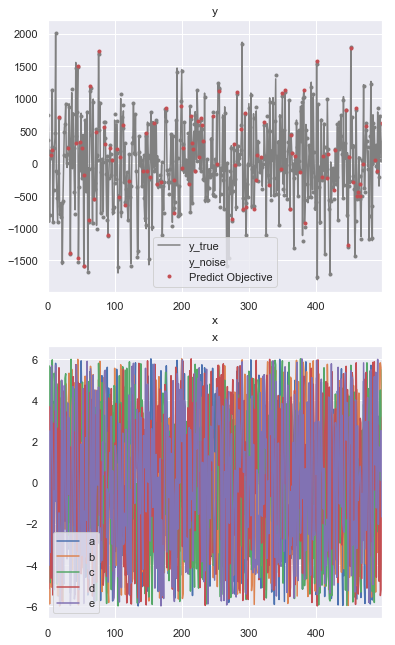

In [6]:
fig, ax = plt.subplots(2,1, figsize=(6,11))
df_x.loc[:,['a', 'b', 'c', 'd', 'e']].plot(ax=ax[1])
pd.DataFrame(
    {'x': df_x.index,
     'y_true': y_true}).plot(x='x', ax=ax[0], style='-', color='gray')
pd.DataFrame(
    {'x': df_x.index,
     'y_noise': y_noise}).plot(x='x', ax=ax[0], style='.', color='gray')
pd.DataFrame(
    {'x': df_new_x.index,
     'Predict Objective': new_y_true}).plot(x='x', ax=ax[0], style='.', color='r')
ax[0].set_title('y')
ax[1].set_title('x')
plt.show()

## Inverse kernel regression

In [7]:
sample_size = 200  # Size of data to be used in learning.
beta = 0.1  # Kernel parameter
theta = 0.1  # Regularize parameter

# Gaussian Kernel
def kernel(x1, x2, beta=beta):
    return np.exp(- beta * np.linalg.norm(x1 - x2))

# Sampling teacher data.
df = df_x.sample(sample_size)
selected_x = df.loc[:, ['a', 'b', 'c', 'd', 'e']].values
selected_y = df.loc[:, 'y_noise'].values

# Gram matrix.
K = np.zeros((sample_size, sample_size))
for i in range(sample_size):
    for j in range(sample_size):
        K[i,j] = kernel(selected_x[i], selected_x[j])
        

In [18]:
# Compute Inverse of Yt@K@Y
YtKY = selected_y*K*selected_y.T
YtKYinv = np.linalg.pinv(YtKY)
YtKYinv.shape

(200, 200)

In [40]:
np.matrix([1,2])*np.array([[2,3],[4,5]])*(np.matrix([1,2]).T)

matrix([[36]])

In [19]:
# selected_y_m = np.matrix(selected_y).T
# K_m = np.matrix(K)
# print(selected_y_m.shape)
# print(K_m.shape)
# print((selected_y.T@K).shape)
# print((selected_y.T@K@selected_y).shape)


In [20]:
# Compute SY
SY = (1./sample_size) * selected_y.T@selected_y
SY

480248.8452823391

In [11]:
(SY*YtKYinv@selected_y).shape

(200,)

In [12]:
# Weight of new data of each data point. 
w_x = np.zeros((sample_size, size_p))
for i in range(sample_size):
    for j in range(size_p):
        w_x[i, j] = kernel(new_x[j, :], selected_x[i, :])  
print(w_x.shape)

(200, 100)


In [24]:
# Prediction
# y_predict = np.zeros(size_p)
y_predict = (SY*YtKYinv@selected_y)@w_x
y_predict.shape

(100,)

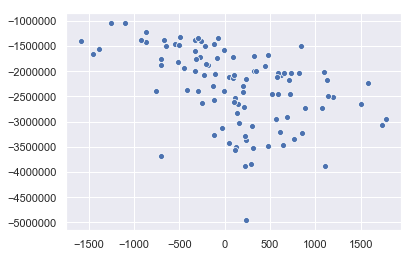

In [25]:
sns.scatterplot(x=new_y_true, y=y_predict)
plt.show()

In [15]:
SY

480248.8452823391

In [26]:
selected_x.shape

(200, 5)